<a href="https://colab.research.google.com/github/saivineeth181/Advertising/blob/master/capstone_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# New section

In [ ]:
!pip install tensorflow==2
# %tensorflow_version 2.x
# !pip install jedi==0.10
# !pip install h5py==2.10.0 --force-reinstall

In [3]:
from tensorflow.python.keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard
from tensorflow.python.keras.engine.network import Network
from tensorflow.python.keras.layers import *
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.preprocessing import image
import tensorflow.python.keras.backend as K

import matplotlib.pyplot as plt

import numpy as np
import os
import random
import scipy.misc
from tqdm import *
import cv2

%matplotlib inline

In [1]:
import tensorflow as tf
print(tf.__version__)

2.0.0


## Config

In [4]:
### Constants ###
DATA_DIR = "/content/drive/MyDrive/capstone_data/tiny-imagenet-200"
TRAIN_DIR = os.path.join(DATA_DIR, "train")
TEST_DIR = os.path.join(DATA_DIR, "test")

IMG_SHAPE = (64, 64)

## Dataset creation


In [6]:
def load_dataset_small(num_images_per_class_train=10, num_images_test=500):
    
    X_train = []
    X_test = []
    
    # Create training set.
    for c in os.listdir(TRAIN_DIR):
        c_dir = os.path.join(TRAIN_DIR, c, 'images')
        c_imgs = os.listdir(c_dir)
        random.shuffle(c_imgs)
        for img_name_i in c_imgs[0:num_images_per_class_train]:
            img_i = image.load_img(os.path.join(c_dir, img_name_i))
            x = image.img_to_array(img_i)
            X_train.append(x)
    random.shuffle(X_train)
    
    # Create test set.
    test_dir = os.path.join(TEST_DIR, 'images')
    test_imgs = os.listdir(test_dir)
    random.shuffle(test_imgs)
    for img_name_i in test_imgs[0:num_images_test]:
        img_i = image.load_img(os.path.join(test_dir, img_name_i))
        x = image.img_to_array(img_i)
        X_test.append(x)

    # Return train and test data as numpy arrays.
    return np.array(X_train), np.array(X_test)

In [ ]:
# Load dataset.
X_train_orig, X_test_orig = load_dataset_small()

# Normalize image vectors.
X_train = X_train_orig/255.
X_test = X_test_orig/255.

# Print statistics.
print ("Number of training examples = " + str(X_train.shape[0]))
print ("Number of test examples = " + str(X_train.shape[0]))
print ("X_train shape: " + str(X_train.shape)) 

In [ ]:
# We split training set into two halfs.
# First half is used for training as secret images, second half for cover images.

# S: secret image
input_S = X_train[0:X_train.shape[0] // 2]

# C: cover image
input_C = X_train[X_train.shape[0] // 2:]

In [ ]:
# Show sample images from the training dataset
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    # Randomly sample from training dataset
    img_idx = np.random.choice(X_train.shape[0])
    fig.add_subplot(rows, columns, i)
    plt.imshow(X_train[img_idx])
plt.show()

## Model

In [5]:
# Variable used to weight the losses of the secret and cover images (See paper for more details)
beta = 1.0
    
# Loss for reveal network
def rev_loss(s_true, s_pred):
    # Loss for reveal network is: beta * |S-S'|
    return beta * K.sum(K.square(s_true - s_pred))

# Loss for the full model, used for preparation and hidding networks
def full_loss(y_true, y_pred):
    # Loss for the full model is: |C-C'| + beta * |S-S'|
    s_true, c_true = y_true[...,0:3], y_true[...,3:6]
    s_pred, c_pred = y_pred[...,0:3], y_pred[...,3:6]
    
    s_loss = rev_loss(s_true, s_pred)
    c_loss = K.sum(K.square(c_true - c_pred))
    
    return s_loss + c_loss


# Returns the encoder as a Keras model, composed by Preparation and Hiding Networks.
def make_encoder(input_size):
    input_S = Input(shape=(input_size))
    input_C= Input(shape=(input_size))

    # Preparation Network
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_3x3')(input_S)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_4x4')(input_S)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_5x5')(input_S)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x = concatenate([input_C, x])
    
    # Hiding network
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid4_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid4_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid5_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    output_Cprime = Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='relu', name='output_C')(x)
    
    return Model(inputs=[input_S, input_C],
                 outputs=output_Cprime,
                 name = 'Encoder')

# Returns the decoder as a Keras model, composed by the Reveal Network
def make_decoder(input_size, fixed=False):
    
    # Reveal network
    reveal_input = Input(shape=(input_size))
    
    # Adding Gaussian noise with 0.01 standard deviation.
    input_with_noise = GaussianNoise(0.01, name='output_C_noise')(reveal_input)
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_3x3')(input_with_noise)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_4x4')(input_with_noise)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_5x5')(input_with_noise)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev4_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev4_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev5_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    output_Sprime = Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='relu', name='output_S')(x)
    
    if not fixed:
        return Model(inputs=reveal_input,
                     outputs=output_Sprime,
                     name = 'Decoder')
    else:
        return Container(inputs=reveal_input,
                         outputs=output_Sprime,
                         name = 'DecoderFixed')

# Full model.
def make_model(input_size):
    input_S = Input(shape=(input_size))
    input_C= Input(shape=(input_size))
    
    encoder = make_encoder(input_size)
    
    decoder = make_decoder(input_size)
    decoder.compile(optimizer='adam', loss=rev_loss)
    decoder.trainable = False
    
    output_Cprime = encoder([input_S, input_C])
    output_Sprime = decoder(output_Cprime)

    autoencoder = Model(inputs=[input_S, input_C],
                        outputs=concatenate([output_Sprime, output_Cprime]))
    autoencoder.compile(optimizer='adam', loss=full_loss)
    
    return encoder, decoder, autoencoder

In [6]:
encoder_model, reveal_model, autoencoder_model = make_model((256,256,3))

In [ ]:
encoder_model.summary()

## Training

Although the author of the paper didn't explicitly described the learning rate schedule or the optimizer properties, we used our own schedule with ADAM optimizer. We train for 1000 epochs with a batch size of 32. 

In [8]:
def lr_schedule(epoch_idx):
    if epoch_idx < 200:
        return 0.001
    elif epoch_idx < 400:
        return 0.0003
    elif epoch_idx < 600:
        return 0.0001
    else:
        return 0.00003

In [ ]:
NB_EPOCHS = 1000
BATCH_SIZE = 32

m = input_S.shape[0]
loss_history = []
for epoch in range(NB_EPOCHS):
    np.random.shuffle(input_S)
    np.random.shuffle(input_C)
    
    t = tqdm(range(0, input_S.shape[0], BATCH_SIZE),mininterval=0)
    ae_loss = []
    rev_loss = []
    for idx in t:
        
        batch_S = input_S[idx:min(idx + BATCH_SIZE, m)]
        batch_C = input_C[idx:min(idx + BATCH_SIZE, m)]
        
        C_prime = encoder_model.predict([batch_S, batch_C])
        
        ae_loss.append(autoencoder_model.train_on_batch(x=[batch_S, batch_C],
                                                   y=np.concatenate((batch_S, batch_C),axis=3)))
        rev_loss.append(reveal_model.train_on_batch(x=C_prime,
                                              y=batch_S))
        
        # Update learning rate
        K.set_value(autoencoder_model.optimizer.lr, lr_schedule(epoch))
        K.set_value(reveal_model.optimizer.lr, lr_schedule(epoch))
        
        t.set_description('Epoch {} | Batch: {:3} of {}. Loss AE {:10.2f} | Loss Rev {:10.2f}'.format(epoch + 1, idx, m, np.mean(ae_loss), np.mean(rev_loss)))
    loss_history.append(np.mean(ae_loss))

In [ ]:
# Plot loss through epochs
plt.plot(loss_history)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [ ]:
# Save model
#autoencoder_model.save_weights('deep-steg-master/models/weights_final.hdf5')

In [9]:
# Load model
autoencoder_model.load_weights('/content/drive/MyDrive/deep-steg-master/models/weights_final.hdf5')

## Results

In [ ]:
# Retrieve decoded predictions.
decoded = autoencoder_model.predict([input_S, input_C])
decoded_S, decoded_C = decoded[...,0:3], decoded[...,3:6]
# Get absolute difference between the outputs and the expected values.
diff_S, diff_C = np.abs(decoded_S - input_S), np.abs(decoded_C - input_C) 

In [ ]:
def pixel_errors(input_S, input_C, decoded_S, decoded_C):
    """Calculates mean of Sum of Squared Errors per pixel for cover and secret images. """
    see_Spixel = np.sqrt(np.mean(np.square(255*(input_S[0] - decoded_S))))
    see_Cpixel = np.sqrt(np.mean(np.square(255*(input_C[0] - decoded_C))))
    
    return see_Spixel, see_Cpixel

def pixel_histogram(diff_S, diff_C):
    """Calculates histograms of errors for cover and secret image. """
    diff_Sflat = diff_S.flatten()
    diff_Cflat = diff_C.flatten()
    
    fig = plt.figure(figsize=(15, 5))
    a=fig.add_subplot(1,2,1)
        
    imgplot = plt.hist(255* diff_Cflat, 100, alpha=0.75,density=True)
    a.set_title('Distribution of error in the Cover image.')
    plt.axis([0, 250, 0, 0.2])
    
    a=fig.add_subplot(1,2,2)
    imgplot = plt.hist(255* diff_Sflat, 100, alpha=0.75,density=True)
    a.set_title('Distribution of errors in the Secret image.')
    plt.axis([0, 250, 0, 0.2])
    
    plt.show()

In [ ]:
# Print pixel-wise average errors in a 256 scale.
S_error, C_error = pixel_errors(input_S[0], input_C[0], decoded_S, decoded_C)

print ("S error per pixel [0, 255]:", S_error)
print ("C error per pixel [0, 255]:", C_error)

In [ ]:
# Plot distribution of errors in cover and secret images.
pixel_histogram(diff_S, diff_C)

In [ ]:
# Configs for results display

# Show images in gray scale
SHOW_GRAY = False
# Show difference bettwen predictions and ground truth.
SHOW_DIFF = True

# Diff enhance magnitude
ENHANCE = 1

# Number of secret and cover pairs to show.
n = 6

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

def show_image(img, n_rows, n_col, idx, gray=False, first_row=False, title=None):
    ax = plt.subplot(n_rows, n_col, idx)
    if gray:
        plt.imshow(rgb2gray(img), cmap = plt.get_cmap('gray'))
    else:
        plt.imshow(img)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if first_row:
        plt.title(title)

plt.figure(figsize=(14, 15))
rand_indx = [random.randint(0, 1000) for x in range(n)]
for i, idx in enumerate(range(0, n)):
#for i, idx in enumerate(rand_indx):
    n_col = 6 if SHOW_DIFF else 4
    
    show_image(input_C[idx], n, n_col, i * n_col + 1, gray=SHOW_GRAY, first_row=i==0, title='Cover')

    show_image(input_S[idx], n, n_col, i * n_col + 2, gray=SHOW_GRAY, first_row=i==0, title='Secret')
    
    show_image(decoded_C[idx], n, n_col, i * n_col + 3, gray=SHOW_GRAY, first_row=i==0, title='Encoded Cover')
    
    show_image(decoded_S[idx], n, n_col, i * n_col + 4, gray=SHOW_GRAY, first_row=i==0, title='Decoded Secret')

    
    if SHOW_DIFF:
        show_image(np.multiply(diff_C[idx], ENHANCE), n, n_col, i * n_col + 5, gray=SHOW_GRAY, first_row=i==0, title='Diff Cover')
        
        show_image(np.multiply(diff_S[idx], ENHANCE), n, n_col, i * n_col + 6, gray=SHOW_GRAY, first_row=i==0, title='Diff Secret')

plt.show()

##DCT Compression

In [11]:
import numpy as np

jpeg_quantiz_matrix = np.array([[16, 11, 10, 16, 24, 40, 51, 61],
                                [12, 12, 14, 19, 26, 58, 60, 55],
                                [14, 13, 16, 24, 40, 57, 69, 56],
                                [14, 17, 22, 29, 51, 87, 80, 62],
                                [18, 22, 37, 56, 68, 109, 103, 77],
                                [24, 35, 55, 64, 81, 104, 113, 92],
                                [49, 64, 78, 87, 103, 121, 120, 101],
                                [72, 92, 95, 98, 112, 100, 103, 99]])


def chunks(l, n):

    for i in range(0, len(l), n):
        yield l[i:i + n]


def zig_zag(array, n=None):


    shape = np.array(array).shape

    assert len(shape) >= 2

    if n is None:
        n = shape[0] * shape[1]
    assert 0 <= n <= shape[0] * shape[1]

    res = np.zeros_like(array)

    (j, i) = (0, 0)
    direction = 'r'  
    for subel_num in range(1, n + 1):
        res[j][i] = array[j][i]
        if direction == 'r':
            i += 1
            if j == shape[0] - 1:
                direction = 'ur'
            else:
                direction = 'dl'
        elif direction == 'dl':
            i -= 1
            j += 1
            if j == shape[0] - 1:
                direction = 'r'
            elif i == 0:
                direction = 'd'
        elif direction == 'd':
            j += 1
            if i == 0:
                direction = 'ur'
            else:
                direction = 'dl'
        elif direction == 'ur':
            i += 1
            j -= 1
            if i == shape[1] - 1:
                direction = 'd'
            elif j == 0:
                direction = 'r'

    return res

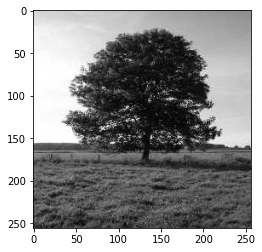

In [12]:
import itertools
import math
from PIL import Image
import cv2 as cv
import numpy as np


def compress(img, num_coeffs=None, scale_factor=1):


    img = np.float32(img)

    # prevent against multiple-channel images
    if len(img.shape) != 2:
        raise ValueError('Input image must be a single channel 2D array')

    # shape of image
    h, w = img.shape

    # No of blocks needed : Calculation

    # new block height
    n_height = np.int32(math.ceil(h / 8)) * 8

    # new block width
    n_width = np.int32(math.ceil(w / 8)) * 8

    # create a numpy zero matrix with size of H,W
    padded_img = np.zeros((n_height, n_width))

    padded_img[0:h, 0:w] = img

    img = np.float32(padded_img)
    height, width = img.shape

    # split into blocks
    img_blocks = [img[j:j + 8, i:i + 8]
                  for (j, i) in itertools.product(range(0, height, 8),
                                                  range(0, width, 8))]

    # DCT transform every block
    dct_blocks = [cv.dct(img_block) for img_block in img_blocks]

    if num_coeffs is not None:
        # keep only the first K DCT coefficients of every block
        reduced_dct_coeffs = [zig_zag(dct_block, num_coeffs) for dct_block in dct_blocks]
    else:
        # quantize all the DCT coefficients using the quantization matrix and the scaling factor
        reduced_dct_coeffs = [np.round(dct_block / (jpeg_quantiz_matrix * scale_factor))
                              for dct_block in dct_blocks]

        # and get the original coefficients back
        reduced_dct_coeffs = [reduced_dct_coeff * (jpeg_quantiz_matrix * scale_factor)
                              for reduced_dct_coeff in reduced_dct_coeffs]

    # IDCT of every block
    rec_img_blocks = [cv.idct(coeff_block) for coeff_block in reduced_dct_coeffs]

    # reshape the reconstructed image blocks
    rec_img = []
    for chunk_row_blocks in chunks(rec_img_blocks, width // 8):
        for row_block_num in range(8):
            for block in chunk_row_blocks:
                rec_img.extend(block[row_block_num])
    rec_img = np.array(rec_img).reshape(height, width)

    # round to the nearest integer [0,255] value
    rec_img[rec_img < 0] = 0
    rec_img[rec_img > 255] = 255
    rec_img = np.uint8(rec_img)
    im = Image.fromarray(rec_img[0:h, 0:w])
    im.save("/content/drive/MyDrive/capstone_data/compressed.jpeg")
    return rec_img[0:h, 0:w]
img = cv2.imread('/content/drive/MyDrive/capstone_data/tree.jpg',0)
img = cv2.resize(img,(256,256))
img = compress(img)
plt.imshow(img,cmap=plt.get_cmap('gray'))

In [13]:
print('Size of image:',int(os.path.getsize('/content/drive/MyDrive/capstone_data/tree.jpg')/1024),'kb')
print('Size of compressed image:',int(os.path.getsize('/content/drive/MyDrive/capstone_data/compressed.jpeg')/1024),'kb')

Size of image: 109 kb
Size of compressed image: 13 kb


## Encryption

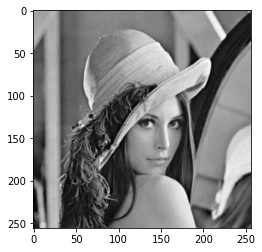

In [14]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import math

img = cv2.imread('/content/drive/MyDrive/capstone_data/Lenna_(test_image).png',0)
img = cv2.resize(img,(256,256))
plt.imshow(img,cmap=plt.get_cmap('gray'))

In [15]:
#Creation of diffusion key
def floatintoint(arr):
  l = []
  for i in arr:
    l.append(int(i))
  return l

p = 3.628
k=[]
k.append(0.632)

for n in range(0,img.shape[0]*img.shape[1]-1):
    k.append(math.cos(p*math.acos(k[n])))

k = np.array(k)

k = np.abs(np.round(k*255))

k = k.astype(np.int64)

ktemp = np.insert(k[:-1], 0, k[-1])


key=np.bitwise_xor(k,ktemp) 
#Ending creation of diffusion key

x=[]
r = 3.99
x.append(0.7)
row=img.shape[0]
col=img.shape[1]
s = row*col
#Creation of Logistic function
for n in range(0,s-1):
  x.append(r*x[n]*(1-x[n]))
arr=np.array(x)

so=np.sort(arr, axis=0) 
ni=np.argsort(arr)

#[ so , ni] = np.sort(x) #ascending]

In [16]:
def encrypt(img):
  timg = img.copy()
  #Start of Confusion
  timg = timg.flatten()

  for m in range (0,timg.shape[0]):    
      t1 = timg[m]

      timg[m] = timg[ni[m]]
      timg[int(ni[m])] = t1 
  #End of confussion
  #Final Encryption Starts
  timg = np.bitwise_xor(np.uint8(key),np.uint8(timg).flatten())
  himg = timg.reshape(row,col)
  #Final Encryption Ends
  return himg

In [17]:
def decrypt(himg):
  #Decryption Start
  dimg = np.bitwise_xor(np.uint8(key),np.uint8(himg).flatten())
  m=dimg.shape[0]
  for m in range(m)[::-1]:
    t1 = dimg[m]
    t2 = ni[m]
    dimg[m]=dimg[int(t2)]
    dimg[int(t2)]=t1
  dimg = dimg.reshape(row,col);

  #Decryption End
  return dimg

In [18]:
eimg = encrypt(img)
dimg = decrypt(eimg)

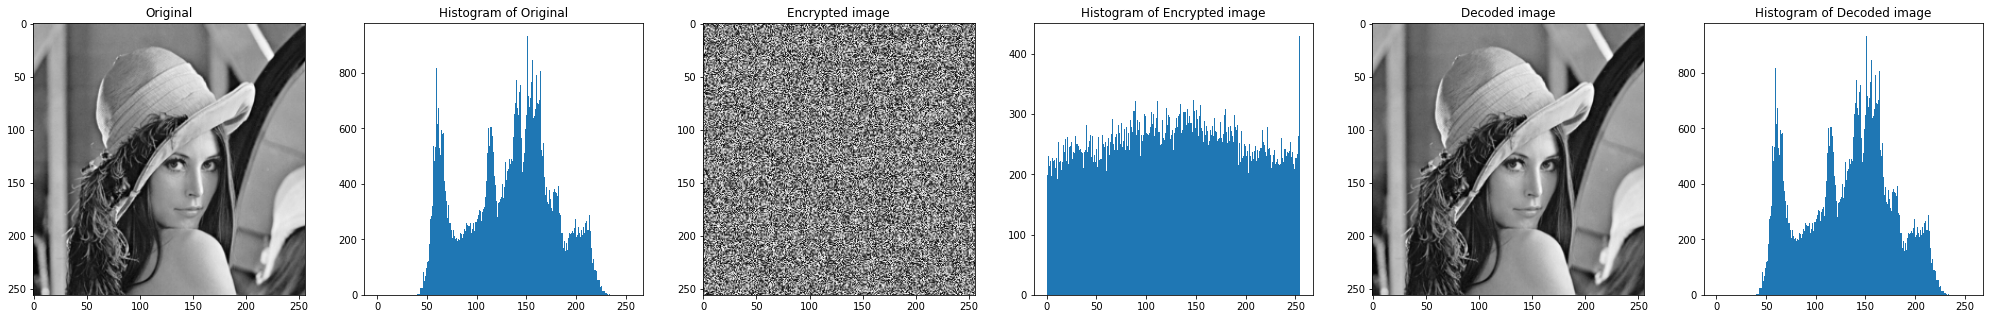

In [19]:
plt.figure(figsize=(35, 5))
plt.subplot(1,6,1)
plt.title('Original')
plt.imshow(img,cmap=plt.get_cmap('gray'));
plt.subplot(1,6,2)
plt.title('Histogram of Original')
plt.hist(img.flatten(),range(256))
plt.subplot(1,6,3)
plt.title('Encrypted image')
plt.imshow(eimg,cmap=plt.get_cmap('gray'))
plt.subplot(1,6,4)
plt.title('Histogram of Encrypted image')
plt.hist(eimg.flatten(),range(256))
plt.subplot(1,6,5)
plt.title('Decoded image')
plt.imshow(dimg,cmap=plt.get_cmap('gray'))
plt.subplot(1,6,6)
plt.title('Histogram of Decoded image')
plt.hist(dimg.flatten(),range(256))
plt.show()

##PERFORMANCE MEASURES for Encryption

In [ ]:
input = cv2.imread("/content/drive/MyDrive/capstone_data/tree.jpg",0)
input = cv2.resize(input,(256,256))


encrypt1 = encrypt(input)

input[50][50] = input[50][50] -1
input1 = input

encrypt2 = encrypt(encrypt(input1))

plt.figure(figsize=(20, 50))
plt.subplot(1,4,1)
plt.imshow(input,cmap=plt.get_cmap('gray'))
plt.title('Original')
plt.subplot(1,4,2)
plt.imshow(encrypt1,cmap=plt.get_cmap('gray'))
plt.title('Encrypted image')
plt.subplot(1,4,3)
plt.imshow(input,cmap=plt.get_cmap('gray'))
plt.title('Original')
plt.subplot(1,4,4)
plt.imshow(encrypt2,cmap=plt.get_cmap('gray'))
plt.title('Encrypted image')
plt.show()

In [ ]:
def sumofpixelval(height,width,img1,img2):
  matrix = np.empty([width,height])
  for y in range(0,height):
    for x in range(0,width):
      if img1[x,y] == img2[x,y]:
        matrix[x,y] = 0
      else:
        matrix[x,y] = 1
  psum = 0
  for y in range(0,height):
    for x in range(0,width):
      psum = matrix[x,y] + psum
  return psum

def npcr(img1,img2):
  height = img1.shape[0]
  width = img2.shape[1]
  npcr = ((sumofpixelval(height,width,img1,img2)/(height*width))*100)
  return npcr

print('NPCR: ',npcr(encrypt1,encrypt2))

In [ ]:
def uaci(img1,img2):
  height,width = img1.shape
  value = 0
  for y in range(height):
    for x in range(width):
      value+=(abs(int(img1[x,y]) - int(img2[x,y])))
  value=value*100/(width*height*255)
  return value
print("UACI :" ,uaci(encrypt1,encrypt2))

##Testing

In [ ]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

In [ ]:
input = cv2.imread("/content/drive/MyDrive/capstone_data/cover.jpg")
input = cv2.cvtColor(input,cv2.COLOR_BGR2RGB)
input = cv2.resize(input,(256,256))
cover_img = rgb2gray(input).astype(int)/255

cover = np.zeros(input.shape)
cover[:,:,0] = cover_img
cover[:,:,1] = cover_img
cover[:,:,2] = cover_img
plt.imshow(cover)


In [ ]:
secret_img = cv2.imread("/content/drive/MyDrive/capstone_data/compressed.jpeg",0)
secret_img = secret_img /255
secret = np.zeros((256,256,3))
secret[:,:,0] = secret_img
secret[:,:,1] = secret_img
secret[:,:,2] = secret_img


plt.imshow(secret,cmap=plt.get_cmap('gray'))


In [ ]:
ex = autoencoder_model.predict([[secret], [cover]])
decoded_S, decoded_C = ex[...,0:3], ex[...,3:6]
diff_S, diff_C = np.abs(decoded_S - secret), np.abs(decoded_C - cover)

In [ ]:
ENHANCE = 1

n = 6


def show_image(img, n_rows, n_col,idx,title=None):
    ax = plt.subplot(n_rows, n_col,idx)

    plt.imshow(img,cmap=plt.get_cmap('gray'))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.title(title)


plt.figure(figsize=(20,20))
show_image(cover ,1,6,1, title='Cover')

show_image(secret,1,6,2, title='Secret')

show_image(decoded_C[0] ,1,6,3,  title='Encoded Cover')

show_image(decoded_S[0] ,1,6,4, title='Decoded Secret')

show_image(np.multiply(diff_C[0], ENHANCE), n_rows=1, n_col=6,idx=5, title='Diff Cover')
        
show_image(np.multiply(diff_S[0], ENHANCE), 1, 6, 6, title='Diff Secret')


plt.show()

In [ ]:
plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.hist(cover.flatten())
plt.title('Original Cover Image')
plt.subplot(1,2,2)
plt.hist(decoded_C.flatten())
plt.title('Encoded Cover')
plt.show()

In [ ]:
plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.hist((255*secret).astype(int).flatten(),range(256))
plt.title('Original Secret Image')
plt.subplot(1,2,2)
plt.hist((255*decoded_S).astype(int).flatten(),range(256))
plt.title('Decoded Secret')
plt.show()

In [ ]:
import math
import cv2
import numpy as np

def psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    print("mse:",mse)
    if mse == 0:
        return 100
    PIXEL_MAX = 255.0
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

d = psnr(secret, decoded_S[0].astype(int))
print("psnr: ",d)

In [ ]:
from skimage.metrics import structural_similarity as compare_ssim

(score, diff) = compare_ssim(cover, decoded_C[0], full=True,multichannel=True)
diff = (diff * 255).astype("uint8")
print("SSIM: {}".format(score))

In [ ]:
def bpp(img1,img2):
  img1_shape = img1.shape
  img2_shape = img2.shape
  return (img1.sum())/(img2_shape[0]*img2_shape[1])
print("BPP: ",bpp(secret,cover))

## Encryption and Steganography

In [20]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

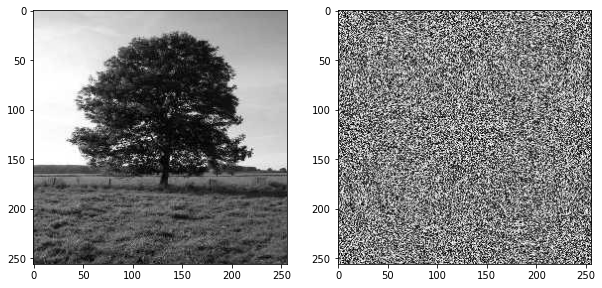

In [21]:
input = cv2.imread("/content/drive/MyDrive/capstone_data/compressed.jpeg")
input = cv2.cvtColor(input,cv2.COLOR_BGR2RGB)
input = cv2.resize(input,(256,256))
secret_img = encrypt(rgb2gray(input).astype(int))/255

secret = np.zeros(input.shape)
secret[:,:,0] = secret_img
secret[:,:,1] = secret_img
secret[:,:,2] = secret_img

plt.figure(figsize=(10, 10))
plt.subplot(1,2,1)
plt.imshow(rgb2gray(input),cmap=plt.get_cmap('gray'))
plt.subplot(1,2,2)
plt.imshow(secret)
plt.show()

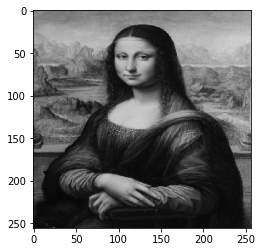

In [22]:
cover_img = image.load_img("/content/drive/MyDrive/capstone_data/cover4.jpg",target_size=(256,256,3))
cover_img = image.img_to_array(cover_img)
cover_img = rgb2gray(cover_img).astype(int)/255

cover = np.zeros(input.shape)
cover[:,:,0] = cover_img
cover[:,:,1] = cover_img
cover[:,:,2] = cover_img
plt.imshow(cover)

In [23]:
ex = autoencoder_model.predict([[secret], [cover]])
decoded_S, decoded_C = ex[...,0:3], ex[...,3:6]
diff_S, diff_C = np.abs(decoded_S - secret), np.abs(decoded_C - cover)

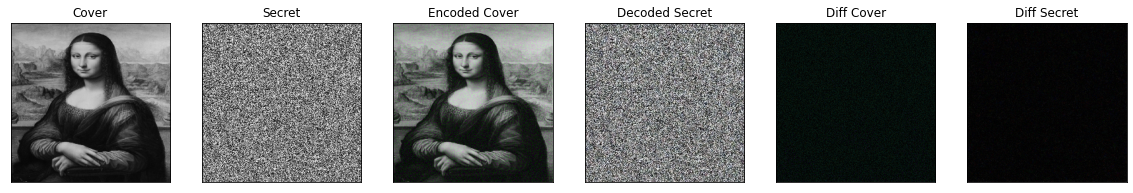

In [24]:
ENHANCE = 1

n = 6

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

def show_image(img, n_rows, n_col,idx,title=None):
    ax = plt.subplot(n_rows, n_col,idx)

    plt.imshow(img,cmap=plt.get_cmap('gray'))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.title(title)

plt.figure(figsize=(20, 20))
    
show_image(cover ,1,6,1, title='Cover')

show_image(secret,1,6,2, title='Secret')

show_image(decoded_C[0] ,1,6,3,  title='Encoded Cover')

show_image(decoded_S[0] ,1,6,4, title='Decoded Secret')

show_image(np.multiply(diff_C[0], ENHANCE), 1, 6,5, title='Diff Cover')
        
show_image(np.multiply(diff_S[0], ENHANCE), 1, 6, 6, title='Diff Secret')


plt.show()

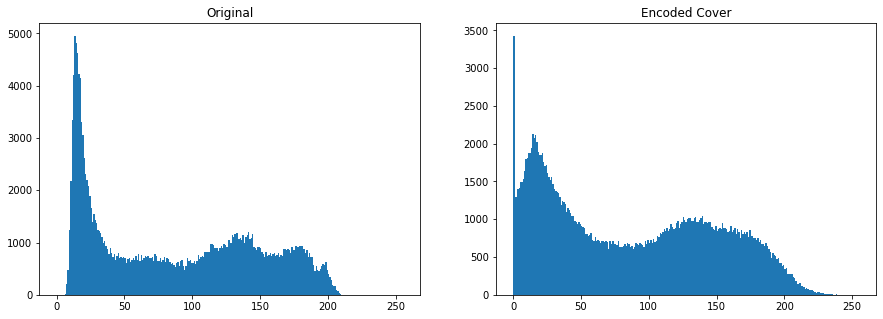

In [25]:
plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.hist(255*cover.flatten(), range(256))
plt.title('Original')
plt.subplot(1,2,2)
plt.hist(255*decoded_C.flatten(), range(256))
plt.title('Encoded Cover')
plt.show()

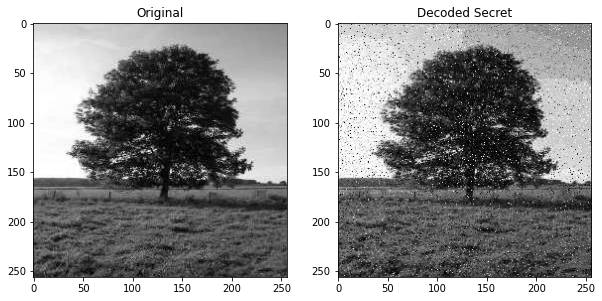

In [26]:
red_channel = (255*decoded_S[0]).astype(int)[:,:,0]
decrypted = decrypt(red_channel)

plt.figure(figsize=(10, 10))
plt.subplot(1,2,1)
plt.imshow(rgb2gray(input).astype(int),cmap=plt.get_cmap('gray'))
plt.title('Original')
plt.subplot(1,2,2)
plt.imshow(decrypted,cmap=plt.get_cmap('gray'))
plt.title('Decoded Secret')
plt.show()

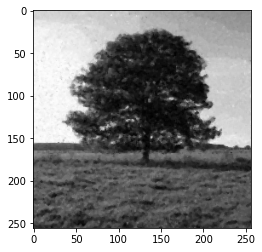

In [27]:
median_blur= cv2.medianBlur(decrypted, 3)
plt.imshow(median_blur,cmap=plt.get_cmap('gray'))  

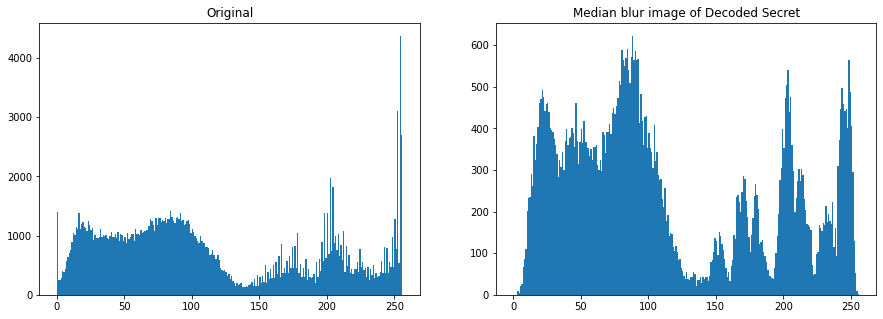

In [28]:
plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.hist(input.astype(int).flatten(), range(257))
plt.title('Original')
plt.subplot(1,2,2)
plt.hist(median_blur.astype(int).flatten(), range(257))
plt.title('Median blur image of Decoded Secret')
plt.show()

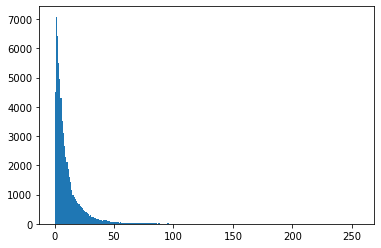

In [29]:
plt.hist(np.abs(rgb2gray(input) - median_blur).flatten(), range(257))
plt.show()